<a href="https://colab.research.google.com/github/DanayaDiarra/MachineLearning/blob/main/CanteenAI_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🍽️Canteen.ai**
## **Meal Classification System for Digital Canteen**

### **Project Description**

This `computer vision` system automates meal pricing in student canteens using `zero-shot classification`. When students place their meal tray under a camera, the system instantly identifies the meal combo and displays the total price. The solution uses CLIP model for classification without requiring training data, making it easy to adapt to different meal combinations.

### **Key Features**

* **Zero-shot meal recognition** : Identifies different meal combos

* **Automatic pricing** : Calculates total cost based on classified meal set

* **Visual meal generation**: Creates realistic images to show how each meal combo looks

* **Real-time deployment ready** : Can integrate with camera systems for instant pricing



The system generates realistic images of each meal combo to help students visualize their options and verify the camera's classification accuracy.

In [ ]:
!pip install transformers torch torchvision pillow requests

In [ ]:
# Install required packages
import requests
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load the pre-trained CLIP model for zero-shot classification
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define meal classes (5 different meal sets)
MEAL_CLASSES = [
    "hamburger with fries and cola",
    "pizza with salad and juice",
    "chicken rice with vegetables and water",
    "pasta with garlic bread and lemonade",
    "sushi set with miso soup and green tea"
]

# Define prices for each meal set (in your local currency)
MEAL_PRICES = {
    "hamburger with fries and cola": 8.99,
    "pizza with salad and juice": 10.50,
    "chicken rice with vegetables and water": 7.25,
    "pasta with garlic bread and lemonade": 9.75,
    "sushi set with miso soup and green tea": 12.99
}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
def zeroshot_classification(image_path, classes):
    """
    Perform zero-shot classification on an image

    Args:
        image_path: Path to the image file or PIL Image object
        classes: List of class labels to classify against

    Returns:
        Dictionary with probabilities for each class
    """
    # Load image
    if isinstance(image_path, str):
        image = Image.open(image_path)
    else:
        image = image_path

    # Prepare inputs
    inputs = processor(text=classes, images=image, return_tensors="pt", padding=True)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Calculate probabilities
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    # Convert to dictionary
    results = {class_name: prob.item() for class_name, prob in zip(classes, probs[0])}

    return results

def get_meal_price(image_path):
    """
    Get the total price for the meal set in the image

    Args:
        image_path: Path to the image file or PIL Image object

    Returns:
        tuple: (predicted_class, confidence, price)
    """
    # Perform classification
    predictions = zeroshot_classification(image_path, MEAL_CLASSES)

    # Get the highest probability class
    predicted_class = max(predictions, key=predictions.get)
    confidence = predictions[predicted_class]

    # Get price
    price = MEAL_PRICES.get(predicted_class, 0)

    return predicted_class, confidence, price

In [ ]:
def display_results(image_path):
    """
    Display classification results in a formatted way
    """
    predicted_class, confidence, price = get_meal_price(image_path)

    print("🍽️ Canteen.ai Classification Results")
    print("-" * 40)
    print(f"📷 Image: {image_path if isinstance(image_path, str) else 'Provided image'}")
    print(f"=> Predicted Meal: {predicted_class}")
    print(f"=> Confidence: {confidence:.2%}")
    print(f"💰 Total Price: ${price:.2f}")
    print("-" * 40)

    return predicted_class, confidence, price

In [ ]:
# Test function with sample URLs or local images
def test_with_sample_images():
    """
    Test the classification system with sample images
    You'll need to replace these URLs with your own meal images
    """
    # Sample image URLs (replace with your actual meal images)
    sample_images = {
        "hamburger": "https://biteswithbri.com/wp-content/uploads/2021/02/HamburgerPattyRecipe04-500x375.jpg",
        "pizza": "https://a.storyblok.com/f/231733/720x300/195685ff02/rezept-pizza_mobil.webp/m/1440x600/filters:format(png):quality(70)",
        "chicken_rice": "https://images.prismic.io/jewishfoodsociety/Znrfs5bWFbowe2JF_Rose_Benjamin_Singaporean_Chicken_Rice_0309.jpg?h=1100&auto=format%2Ccompress&rect=102%2C0%2C6516%2C4480&__type=intro-left-side",
        "pasta": "https://www.pepperbowl.com/wp-content/uploads/2025/02/instant-pot-penne-pasta-recipe.jpg",
        "sushi": "https://api.c2k2y3nvy0-heuschena1-p1-public.model-t.cc.commerce.ondemand.com/medias/625Wx625H-recipe-40.jpg?context=bWFzdGVyfHJvb3R8NDY5NTJ8aW1hZ2UvanBlZ3xhRGt3TDJnME15ODRPRGd4TlRVM056WTJNVGMwTHpZeU5WZDROakkxU0Y5eVpXTnBjR1V0TkRBdWFuQm58ZmY0ZDE3ZDhkNjY0NzE3NzE0MDk3ZWNlNmRhMThmYTNlZmE3NTBjOTg3ZGI2ZmJhMDllMzBlODE4NzIxMjYxZA"
    }

    print("TESTING MEAL CLASSIFICATION SYSTEM (canteen.ai)")
    print("=" * 40)

    for meal_type, image_url in sample_images.items():
        try:
            # Download image
            image = Image.open(requests.get(image_url, stream=True).raw)

            print(f"\nTesting {meal_type}...")
            display_results(image)

        except Exception as e:
            print(f"Error processing {meal_type}: {e}")

In [ ]:
#Generate synthetic images for testing (optional)
def generate_synthetic_test_images():
    """
    Generate synthetic images using text-to-image model for testing
    This requires GPU and additional dependencies
    """
    try:
        # !pip install diffusers accelerate

        from diffusers import StableDiffusionPipeline
        import torch

        # Check if GPU is available
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        # Load stable diffusion model
        pipe = StableDiffusionPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=torch.float16 if device == "cuda" else torch.float32
        )
        pipe = pipe.to(device)

        # Generate images for each meal class
        generated_images = {}

        for meal_class in MEAL_CLASSES:
            print(f"Generating image for: {meal_class}")

            # Generate image
            image = pipe(
                f"professional food photography of {meal_class}, high quality, detailed",
                num_inference_steps=25,
                guidance_scale=7.5
            ).images[0]

            generated_images[meal_class] = image

            # Save image
            image_path = f"{meal_class.replace(' ', '_')}.png"
            image.save(image_path)
            print(f"Saved: {image_path}")
            #plot the images
            plt.imshow(image)
            plt.axis('off')
            plt.show()

        return generated_images

    except Exception as e:
        print(f"Synthetic image generation failed: {e}")
        return None

TESTING MEAL CLASSIFICATION SYSTEM (canteen.ai)

Testing hamburger...
🍽️ Canteen.ai Classification Results
----------------------------------------
📷 Image: Provided image
=> Predicted Meal: hamburger with fries and cola
=> Confidence: 100.00%
💰 Total Price: $8.99
----------------------------------------

Testing pizza...
🍽️ Canteen.ai Classification Results
----------------------------------------
📷 Image: Provided image
=> Predicted Meal: pizza with salad and juice
=> Confidence: 99.99%
💰 Total Price: $10.50
----------------------------------------

Testing chicken_rice...
🍽️ Canteen.ai Classification Results
----------------------------------------
📷 Image: Provided image
=> Predicted Meal: chicken rice with vegetables and water
=> Confidence: 100.00%
💰 Total Price: $7.25
----------------------------------------

Testing pasta...
🍽️ Canteen.ai Classification Results
----------------------------------------
📷 Image: Provided image
=> Predicted Meal: pasta with garlic bread and lemona

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating image for: hamburger with fries and cola


  0%|          | 0/25 [00:00<?, ?it/s]

Saved: hamburger_with_fries_and_cola.png


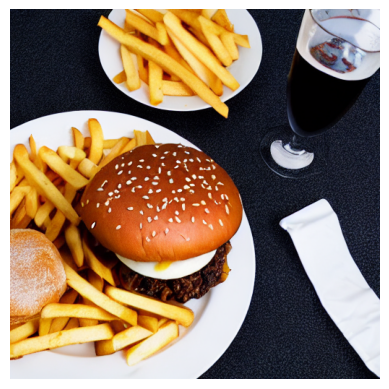

Generating image for: pizza with salad and juice


  0%|          | 0/25 [00:00<?, ?it/s]

Saved: pizza_with_salad_and_juice.png


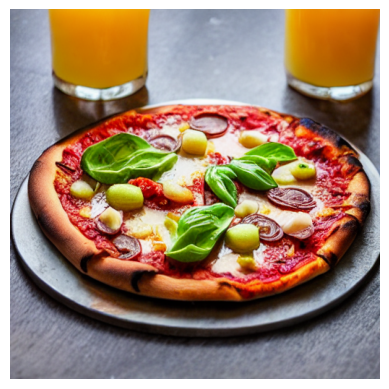

Generating image for: chicken rice with vegetables and water


  0%|          | 0/25 [00:00<?, ?it/s]

Saved: chicken_rice_with_vegetables_and_water.png


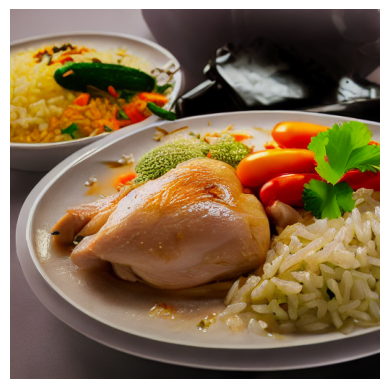

Generating image for: pasta with garlic bread and lemonade


  0%|          | 0/25 [00:00<?, ?it/s]

Saved: pasta_with_garlic_bread_and_lemonade.png


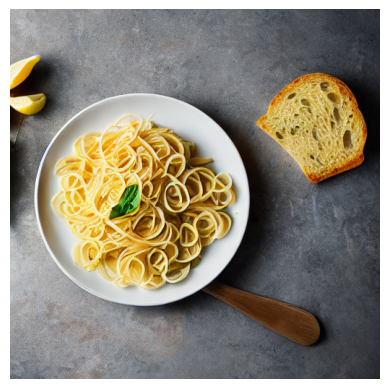

Generating image for: sushi set with miso soup and green tea


  0%|          | 0/25 [00:00<?, ?it/s]

Saved: sushi_set_with_miso_soup_and_green_tea.png


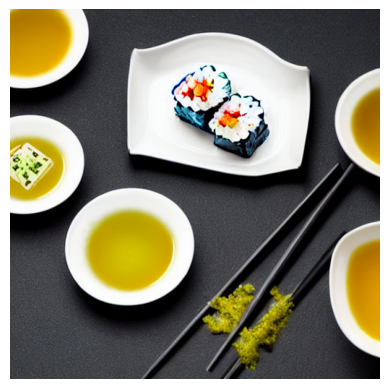


🍽️CANTEEN.AI READY FOR FUTURE DEPLOYMENT===

To use with your own images:
1. Replace sample image URLs with your actual meal tray images
2. Ensure good quality images with clear view of the meal
3. Adjust MEAL_CLASSES and MEAL_PRICES as needed for your canteen


In [ ]:
# Main execution
if __name__ == "__main__":
    # Test with sample images from URLs
    test_with_sample_images()


    generated_images = generate_synthetic_test_images()

    print("\n🍽️CANTEEN.AI READY FOR FUTURE DEPLOYMENT===")
    print("\nTo use with your own images:")
    print("1. Replace sample image URLs with your actual meal tray images")
    print("2. Ensure good quality images with clear view of the meal")
    print("3. Adjust MEAL_CLASSES and MEAL_PRICES as needed for your canteen")